We use the Silhouette Score to optimize the number of clusters. 
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# Setup
Sonja starts by setting up the enviroment she wants to work in.

The Reflexive ML Toolbox relies on external packages that provide useful functionality. For instance, the package *pandas* provides functionality for working with spreadsheet-like data.
These libraries have to be installed to the system that runs the Jupyter Notebook and subsequently loaded (or imported) into the notebook so they can be used in the code.

## Install Packages

Some of the libraries used in this notebook are not installed by default. 
We use the package manager Anaconda to install the missing libraries. 
See the Setup.txt for a step-by-step guide on how to set up Jupyter Lab and Anaconda.

In [1]:
install = False
if install:
    !conda install -c conda-forge html2text -y
    !conda install -c conda-forge sentence-transformers -y
    !conda install pandas --y
    !conda install -c conda-forge matplotlib -y
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y
    !conda install -c districtdatalabs yellowbrick -y

## Imports
We need some libraries to run our code. After importing them into our notebook, we can use them.

We use the following Libraries:

*NumPy (np)* 'is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.' (https://en.wikipedia.org/wiki/NumPy

*Pandas (pd)* 'is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.' (https://pandas.pydata.org/) Pandas represents data in a spreadsheet-like format and allows us to manipulate it accordingly.

*sentence_transformers* 'SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in our paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.
You can use this framework to compute sentence / text embeddings for more than 100 languages. These embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining. The framework is based on PyTorch and Transformers and offers a large collection of pre-trained models tuned for various tasks. Further, it is easy to fine-tune your own models.' (https://www.sbert.net/)

*matplotlib* 'Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.' (https://matplotlib.org/)

In [2]:
import numpy as np

import pandas as pd

from sentence_transformers import SentenceTransformer,util

from html2text import HTML2Text
from tqdm import tqdm

import matplotlib.pyplot as plt

## Set Pandas print options

To get more readable outputs when printing our data in Pandas, we set some print options.

In [3]:
#pandas print options

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load Data

Data Source: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset 

The data is formatted as comma-separated values (csv) and saved as a .csv-file.
We load the data using pandas which will allow us to treat it like a spreadsheet with rows and columns.
Further, we specify, which column contains the text of the tweets.

In [35]:
data = pd.read_csv("twitter_sentiment_data_dates.csv", encoding="'UTF-8'")
text_column = 'message'

We print the first 10 rows of our spreadsheet to make sure we loaded the data correctly.

In [36]:
data.head(10)

,sentiment,message,tweetid,publishedAt
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,2019-10-20
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,2019-12-27
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256,2019-08-13
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,2019-08-09
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,2020-05-12
5,0,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489,2020-10-01
6,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125430236684289,2019-08-03
7,2,"RT @CCIRiviera: Presidential Candidate #DonaldTrump is Ã¢â‚¬Å“dangerousÃ¢â‚¬ï† on climate change, says #monaco Ã¢â‚¬â„¢s Prince AlbertÃ¢â‚¬Â¦",793126558688878592,2019-11-19
8,0,RT @AmericanIndian8: Leonardo DiCaprio's climate change documentary is free for a week https://t.co/ITpdZ6kCeg\n#INDIGENOUS #TAIRP https://tÃ¢â‚¬Â¦,793127097854197761,2020-10-03
9,1,"#BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change... https://t.co/HCIZrPUhLF",793127346106753028,2020-07-30


# Preprocessing

Some preprocessing can be done to produce better embeddings. This step higly depends on the input data. For interviews, we could for example parse out speaker names, such as \*Interviewer says\*:

## Drop unused rows and columns

If Tweets do not contain any text, we drop them, because they would distort results.

Further, we are not interested in the sentiment annotations, so we drop the corresponding column.

In [37]:
data = data.dropna(subset=[text_column]) # drop rows with no content
data = data.drop(['sentiment'], axis = 1)
data.head()

,message,tweetid,publishedAt
0,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,2019-10-20
1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641,2019-12-27
2,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256,2019-08-13
3,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904,2019-08-09
4,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153,2020-05-12


In [38]:
data = data[~data[text_column].str.startswith("RT")].reset_index(drop=True)
data.shape

(18866, 3)

## Remove HTML Tags, Links, User names, new lines

Before we analyze the tweets with our model we clean them to imporve performance.
We filter out:
- HTML-tags
- Links
- New-Line commands

In [39]:
# Remove HTML tags
tqdm.pandas()
h = HTML2Text()
h.ignore_links = True
data['cleaned'] = data[text_column].progress_apply(lambda x: h.handle(x))
print( "Removed HTML Tags")

# Remove links
http_link_pattern = r'http\S+'
bitly_link_pattern = r'bit.ly/\S+'
data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
print( "Removed Links")
  
# Remove new line \n
new_line_pattern = r'\n'
data['cleaned'] = data['cleaned'].str.replace(new_line_pattern, ' ')
print( "Removed new line \n")

data.head()

100%|██████████| 18866/18866 [00:02<00:00, 8527.95it/s]
<ipython-input-39-7e865067b37e>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')


Removed HTML Tags
Removed Links
Removed new line 



<ipython-input-39-7e865067b37e>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
<ipython-input-39-7e865067b37e>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned'] = data['cleaned'].str.replace(new_line_pattern, ' ')


,message,tweetid,publishedAt,cleaned
0,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840,2019-10-20,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256,2019-08-13,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. via @youtube
2,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489,2020-10-01,Unamshow awache kujinga na iko global warming
3,"#BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change... https://t.co/HCIZrPUhLF",793127346106753028,2020-07-30,"#BeforeTheFlood Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change..."
4,"Bangladesh did not cause climate change, so the country does not need Ã¢â‚¬Å“aidÃ¢â‚¬ï†; instead it needs compensation for theÃ¢â‚¬Â¦ https://t.co/ecGXgRNROP",793129746003615745,2019-06-30,"Bangladesh did not cause climate change, so the country does not need Ã¢â‚¬Å“aidÃ¢â‚¬ï†; instead it needs compensation for theÃ¢â‚¬Â¦"


# Embed Data with Universal Sentence Encoder

We want to analyze the content of the tweets with machine learning. For this, we use a model that extracts information. about the content of the tweets. 
Conceptually, the model produces a vector for each of the tweets. The direction of the vectors corrsponds to the tweets' semantic meaning. 
If two vectors point in a similar direction, their semantic meaning is similar.

For example, the tweets "Climate change is dangerous" and "We have to be aware of the dangers of climate change" are similar in meaning so their vectors would point in similar directions. 
The tweet "Polar bears will go extinct" is not as similar to the aforementioned tweets, so it's vector will point to a different direction.

The process of assigning a vector to a piece of text is called *embedding*. 

We use a pretrained neural language model to produce embeddings of the tweets.
The model has been trained with different datasets and has learned a general representation of the semantics of natural language. 

The model we use is called Universal Sentence Encoder:
USE_Multilingual (hosted at: sbert.net , Paper: Yang, Y., Cer, D.M., Ahmad, A., Guo, M., Law, J., Constant, N., Ábrego, G., Yuan, S., Tar, C., Sung, Y., Strope, B., & Kurzweil, R. (2020). Multilingual Universal Sentence Encoder for Semantic Retrieval. ACL.)
(https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/) 

First, we load the model into the notebook and then we assign embeddings to the tweets.

## Load Model

Before we can use the model we have to download it.


In [40]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1/')

## Embed documents

Then we can pass the tweets into the model and it will return embeddings.

For each tweet (i.e. each row in the data frame) one embedding is generated.

In [41]:
batch_size_parameter = 128
print('Embedding...')
data_to_embed = data['cleaned']
embeddings = model.encode(data_to_embed, convert_to_tensor=True, batch_size = batch_size_parameter, show_progress_bar = True)

Embedding...


Batches:   0%|          | 0/148 [00:00<?, ?it/s]

The embeddings are returned as a matrix. Each row in the matrix corresponds to one tweet. Each column corresponds to one dimension of the vectors. Therefore, the matrix has the shape: (number of sentences, number of embedding dimensions)

In [42]:
print(embeddings.shape)
embeddings[:10]

torch.Size([18866, 512])


tensor([[-4.6968e-02, -7.7402e-02, -1.9320e-02,  ...,  1.7619e-02,
          5.0784e-03,  1.2681e-02],
        [ 1.5901e-02, -9.0975e-02, -3.0791e-02,  ..., -2.0671e-02,
         -5.7735e-04,  2.3119e-02],
        [ 5.6255e-03, -6.8567e-02,  1.5634e-02,  ..., -4.3354e-02,
         -3.5120e-02,  3.4669e-02],
        ...,
        [-7.3171e-02, -3.6846e-03, -6.7659e-02,  ...,  9.0373e-03,
          3.6213e-02, -7.4100e-04],
        [ 2.5374e-02, -6.2420e-02, -8.8677e-03,  ..., -2.6728e-02,
         -9.8171e-03,  2.0913e-02],
        [ 8.8709e-03, -3.0195e-02, -2.2284e-02,  ..., -1.9723e-02,
         -7.6648e-07, -1.1837e-03]])

# Reduce dimensionality with UMAP
The embedding vectors assigned to the tweets are high-dimensional. In this case, the dimensionality is 512. 
We reduce the dimensionality to 200 to make it easier for the following algorithm to find clusters of similar tweets.
Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) is used for dimensionality reduction. (https://umap-learn.readthedocs.io/en/latest/)

McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018

An intuitive explanation of UMAP can be found at: https://pair-code.github.io/understanding-umap/

In [43]:
import umap as umap

In [44]:
num_dimensions =200


reducer = umap.UMAP(n_neighbors=30, 
                     n_components=num_dimensions, 
                     metric='cosine',
                    verbose = True,
                    init='spectral',
                     min_dist=.1,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=False
                      )
embeddings_umap = reducer.fit_transform(embeddings)
  

embeddings_reduced = embeddings_umap

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     force_approximation_algorithm=True, metric='cosine', n_components=200,
     n_neighbors=30, verbose=True)
Construct fuzzy simplicial set
Wed Aug 11 15:04:05 2021 Finding Nearest Neighbors
Wed Aug 11 15:04:05 2021 Building RP forest with 12 trees
Wed Aug 11 15:04:06 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Wed Aug 11 15:04:24 2021 Finished Nearest Neighbor Search
Wed Aug 11 15:04:27 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 11 15:06:14 2021 Finished embedding


We can compare embeddings before and after dimensionality reduction by visually expecting their first two dimensions of the vectors.
We use scatterplots in which each (blue) dot corresponds to one of the tweets.
The first plot shows points seemingly randomly spread around the center of the plot.
In the second plot disctinct clusters are visible.

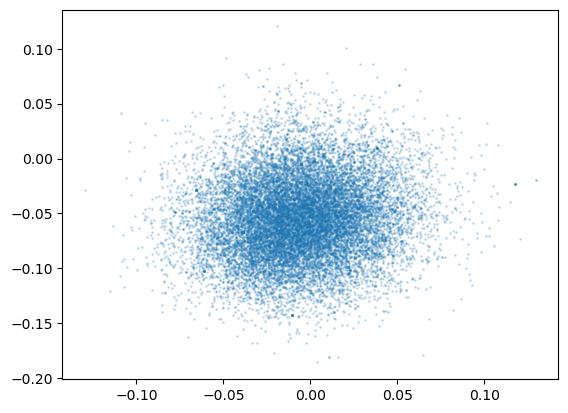

In [45]:
plt.scatter(embeddings[:, 0], embeddings[:,1], alpha=0.2, s = 1)
plt.show()

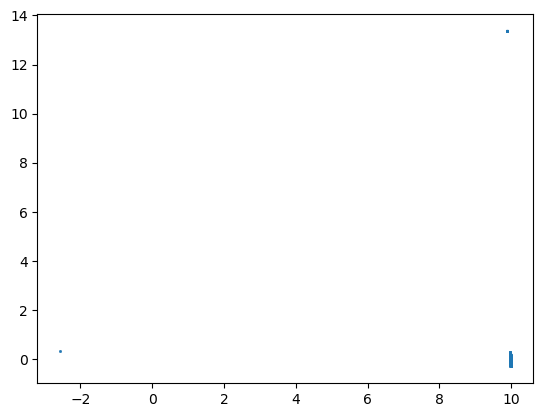

In [46]:
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:,1], alpha=0.2, s = 1)
plt.show()

# Cluster tweets with K-Medoids

We are interested in the topics discussed in the among the tweets.
To do this, we want to find clusters of similar similar embeddings which stand for semantically similar comments. 
We use a method called K-Medoids (https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html#sklearn_extra.cluster.KMedoids)

Maranzana, F.E., 1963. On the location of supply points to minimize transportation costs. IBM Systems Journal, 2(2), pp.129-135.

Park, H.S.and Jun, C.H., 2009. A simple and fast algorithm for K-medoids clustering. Expert systems with applications, 36(2), pp.3336-3341.

For an intuitive explanation of the K-Medoids algorithm, see: https://medium.com/analytics-vidhya/what-is-k-medoid-clustering-why-and-how-b4e518c49e10

**Note: The number of clusters we want to find has to be specified when using K-Medoids. Normally, it is not known beforehand, how many clusters are in the data. Several methods exist to find the otimal number of clusters, for example the elbow method (https://en.wikipedia.org/wiki/Elbow_method_(clustering)), or the Silhouette Score (https://en.wikipedia.org/wiki/Silhouette_(clustering)). For brevity, we assume the optimal number of clusters is set without any additional methods, but instead determined by iterative clustering and expection of the resulting clusters.**

In [48]:
from sklearn_extra.cluster import KMedoids

2
n_clusters: 2 silhouette_avg: 0.22268453
12
n_clusters: 12 silhouette_avg: 0.24681914
22
n_clusters: 22 silhouette_avg: 0.26514888
32
n_clusters: 32 silhouette_avg: 0.27378842
42
n_clusters: 42 silhouette_avg: 0.25560638
52
n_clusters: 52 silhouette_avg: 0.25016424
62
n_clusters: 62 silhouette_avg: 0.26913938
72
n_clusters: 72 silhouette_avg: 0.26924452
82
n_clusters: 82 silhouette_avg: 0.26771724
92
n_clusters: 92 silhouette_avg: 0.26918408
102
n_clusters: 102 silhouette_avg: 0.26520747
112
n_clusters: 112 silhouette_avg: 0.26360968
122
n_clusters: 122 silhouette_avg: 0.26840982
132
n_clusters: 132 silhouette_avg: 0.2747982
142
n_clusters: 142 silhouette_avg: 0.2789637
152
n_clusters: 152 silhouette_avg: 0.28258318
162
n_clusters: 162 silhouette_avg: 0.2758688
172
n_clusters: 172 silhouette_avg: 0.2625663
182
n_clusters: 182 silhouette_avg: 0.26324964
192
n_clusters: 192 silhouette_avg: 0.26776418


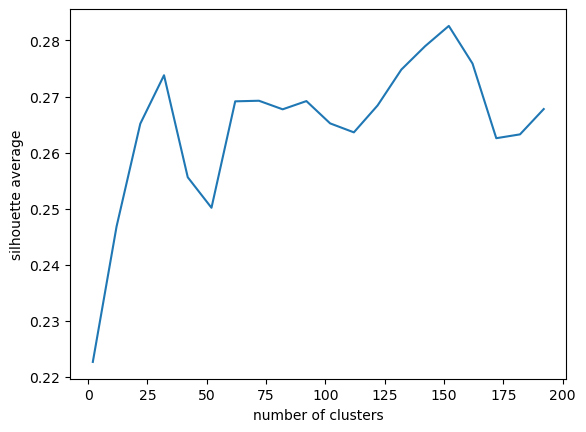

In [49]:
#optimize number of clusters
from sklearn.metrics import silhouette_score
import seaborn as sns
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=200 
step=10 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        print(i)
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)
    plt.show()

In [1]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(clustering,embeddings_reduced, colors='yellowbrick',  is_fitted=True)

NameError: name 'clustering' is not defined